### Cardiovascular Risk Prediction 
#### by Hasna Akbar Ali

##### To predict whether the patient has a 10-year risk of future coronary heart disease (CHD).

### Import Packages

In [1]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

#Supress the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_cardiovascular_risk.csv')
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [3]:
# Make changes only to the copy of a DataFrame, never the original dataframe

df_copy = df.copy()
df_copy.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [4]:
# Analyzing the column names, data types of each column, no of non null values.
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

## Data Cleaning

##### 1. Reformat strings

In [5]:
# Changes made to columns names for easier understanding. 
# Previously in camelCase, now in snake_case

df_copy.rename(columns = {'sex':'gender',
                          'cigsPerDay':'cigs_per_day',
                          'BPMeds':'bp_meds',
                          'prevalentStroke':'prevalent_stroke',
                          'prevalentHyp':'prevalent_hyp',
                          'totChol' : 'tot_chol',
                          'sysBP' :'sys_bp',
                          'diaBP' : 'dia_bp',
                          'BMI':'bmi',
                          'heartRate':'heart_rate',
                          'TenYearCHD' : 'ten_year_chd'
                         }, inplace = True)

print(df_copy.columns)

Index(['id', 'age', 'education', 'gender', 'is_smoking', 'cigs_per_day',
       'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes', 'tot_chol',
       'sys_bp', 'dia_bp', 'bmi', 'heart_rate', 'glucose', 'ten_year_chd'],
      dtype='object')


#### 2. Reformat data types

In [6]:
# category dtype takes up less memory space and time efficiency
# Get a list of columns with object data type
object_columns = df_copy.select_dtypes(include=['object',]).columns

# Convert the object columns to categorical type
df_copy[object_columns] = df_copy[object_columns].astype('category')

nominal_cols = ['prevalent_stroke','prevalent_hyp','diabetes','bp_meds','education']
df_copy[nominal_cols] = df_copy[nominal_cols].astype('category')

In [7]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3390.0,1694.500000,978.753033,0.00,847.25,1694.50,2541.75,3389.0
age,3390.0,49.542183,8.592878,32.00,42.00,49.00,56.00,70.0
cigs_per_day,3368.0,9.069477,11.879078,0.00,0.00,0.00,20.00,70.0
tot_chol,3352.0,237.074284,45.247430,107.00,206.00,234.00,264.00,696.0
sys_bp,3390.0,132.601180,22.292030,83.50,117.00,128.50,144.00,295.0
dia_bp,3390.0,82.883038,12.023581,48.00,74.50,82.00,90.00,142.5
bmi,3376.0,25.794964,4.115449,15.96,23.02,25.38,28.04,56.8
heart_rate,3389.0,75.977279,11.971868,45.00,68.00,75.00,83.00,143.0
glucose,3086.0,82.086520,24.244753,40.00,71.00,78.00,87.00,394.0
ten_year_chd,3390.0,0.150737,0.357846,0.00,0.00,0.00,0.00,1.0


In [8]:
df_copy.count()

id                  3390
age                 3390
education           3303
gender              3390
is_smoking          3390
cigs_per_day        3368
bp_meds             3346
prevalent_stroke    3390
prevalent_hyp       3390
diabetes            3390
tot_chol            3352
sys_bp              3390
dia_bp              3390
bmi                 3376
heart_rate          3389
glucose             3086
ten_year_chd        3390
dtype: int64

#### 3. Remove irrelevant observations

In [9]:
df_copy.drop(columns=['id'],inplace=True)

#### 4. Address missing values

In [10]:
# Identify the null values

null_cols = df_copy.columns[df_copy.isnull().any()].tolist() 
percentage_of_nulls = (df_copy[null_cols].isnull().sum()/len(df_copy)*100)

# What percentage of the column is null
print(percentage_of_nulls)


education       2.566372
cigs_per_day    0.648968
bp_meds         1.297935
tot_chol        1.120944
bmi             0.412979
heart_rate      0.029499
glucose         8.967552
dtype: float64


In [11]:
# 1. 'heart_rate' only 0.02% (1 row) in the data is null, no significant difference in dropping values
df_copy.dropna(subset='heart_rate', inplace=True)

# 2. 'bp_meds' filling with most frequent categorical values 1.29% (44 rows)
# filling with values may not effect the dataset drastically
df_copy['bp_meds'] = df_copy['bp_meds'].fillna(df_copy['bp_meds'].mode()[0])

# 3. 'tot_chol' 1.12% (38 rows) filling with median cause of slight variation in median and mean 
# filling with values may not effect the dataset drastically
df_copy['tot_chol'] = df_copy['tot_chol'].fillna(df_copy['tot_chol'].median())

# 4. 'bmi' filling with most frequent categorical values 0.412% (14 rows)
# filling with values may not effect the dataset drastically
df_copy['bmi'] = df_copy['bmi'].fillna(df_copy['bmi'].mean())

# 5. 'cigs_per_day' 0.648% (22 rows) in the data is null, no significant difference in dropping values
df_copy.dropna(subset='cigs_per_day', inplace=True)

# 6. 'glucose' filling with most frequent categorical values 8.96% (304 rows)
# filling with values may not effect the dataset drastically
df_copy['glucose'] = df_copy['glucose'].fillna(df_copy['glucose'].median())

# 7. 'education' filling with most frequent categorical values 2.56% (87 rows)
# filling with values may not effect the dataset drastically
df_copy['education'] = df_copy['education'].fillna(df_copy['education'].mode()[0])

In [12]:
df_copy.isnull().sum()

age                 0
education           0
gender              0
is_smoking          0
cigs_per_day        0
bp_meds             0
prevalent_stroke    0
prevalent_hyp       0
diabetes            0
tot_chol            0
sys_bp              0
dia_bp              0
bmi                 0
heart_rate          0
glucose             0
ten_year_chd        0
dtype: int64

#### 4. Address duplicate values

In [13]:
duplicates = df.duplicated()
print(duplicates.sum())
# There are no duplicates in the dataset

0


#### 5. Address the outliers

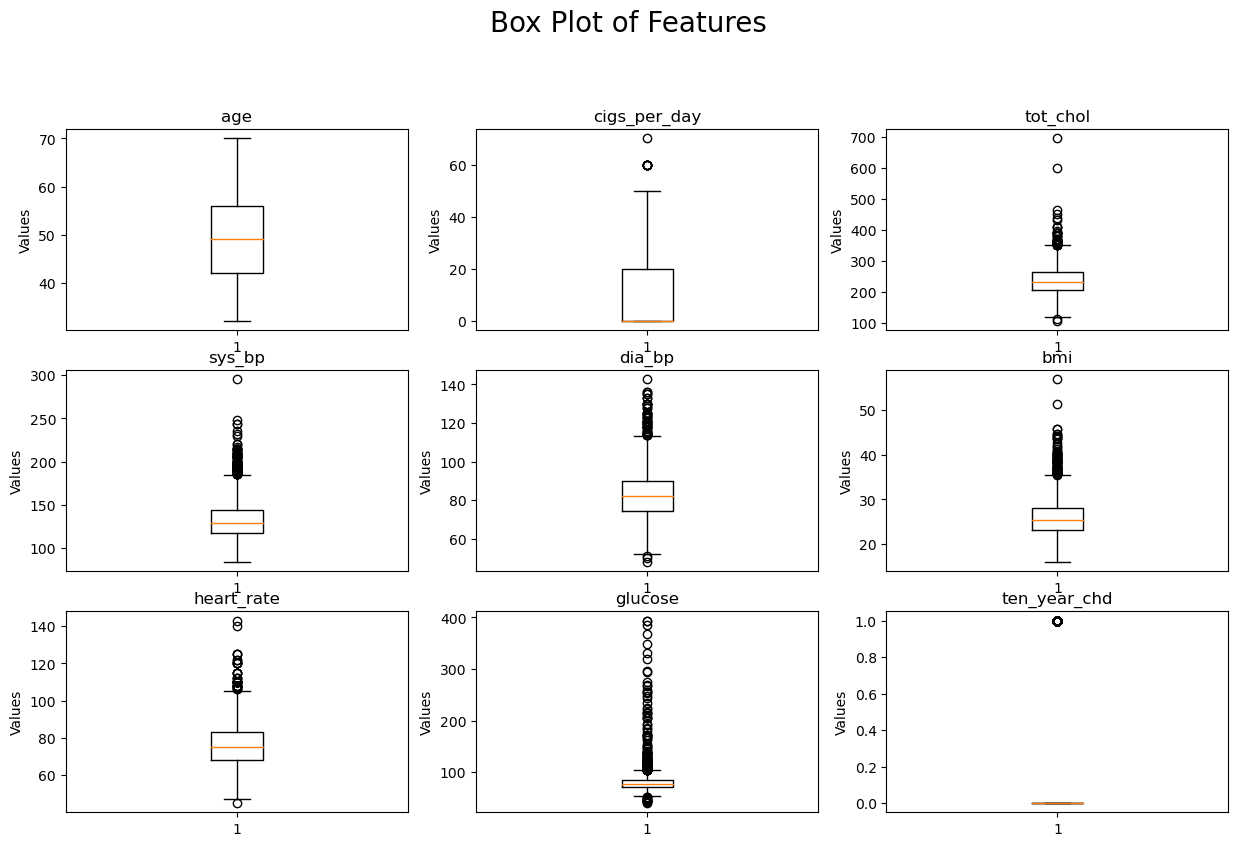

In [14]:
# Checking columns with int64,float64 datatype for outliers
int_columns = df_copy.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(15, 12))
plt.suptitle('Box Plot of Features', fontsize=20)

for i, col in enumerate(int_columns.columns):
    plt.subplot(4, 3, i + 1)  # Create a subplot
    plt.boxplot(int_columns[col])      # Create the box plot
    plt.title(col)            # Set the title
    plt.ylabel('Values')
    
plt.show()  # Display the plots

In [15]:
# Outlier removal is not a good option in medical field 
# as our focus is on outliers

## EDA (Exploratory Data Analysis)

#### 1 (a) Univariate non-graphical EDA for Categorical Data

In [16]:
df_copy.describe(exclude=['int64','float64']).T

,count,unique,top,freq
education,3367.0,4.0,1.0,1467.0
gender,3367,2,F,1913
is_smoking,3367,2,NO,1703
bp_meds,3367.0,2.0,0.0,3267.0
prevalent_stroke,3367,2,0,3345
prevalent_hyp,3367,2,0,2304
diabetes,3367,2,0,3280


#### 1 (b) Univariate non-graphical EDA for Numerical Data

In [17]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3367.0,49.539353,8.601609,32.00,42.00,49.0,56.00,70.0
cigs_per_day,3367.0,9.066825,11.879845,0.00,0.00,0.0,20.00,70.0
tot_chol,3367.0,236.997030,44.957351,107.00,206.00,234.0,264.00,696.0
sys_bp,3367.0,132.589546,22.293352,83.50,117.00,128.5,144.00,295.0
dia_bp,3367.0,82.886991,12.022777,48.00,74.50,82.0,90.00,142.5
bmi,3367.0,25.797421,4.115059,15.96,23.03,25.4,28.01,56.8
heart_rate,3367.0,75.975052,11.967920,45.00,68.00,75.0,83.00,143.0
glucose,3367.0,81.690229,23.201729,40.00,72.00,78.0,85.00,394.0
ten_year_chd,3367.0,0.151173,0.358271,0.00,0.00,0.0,0.00,1.0


#### 2 (a) Univariate graphical EDA for Categorical Data

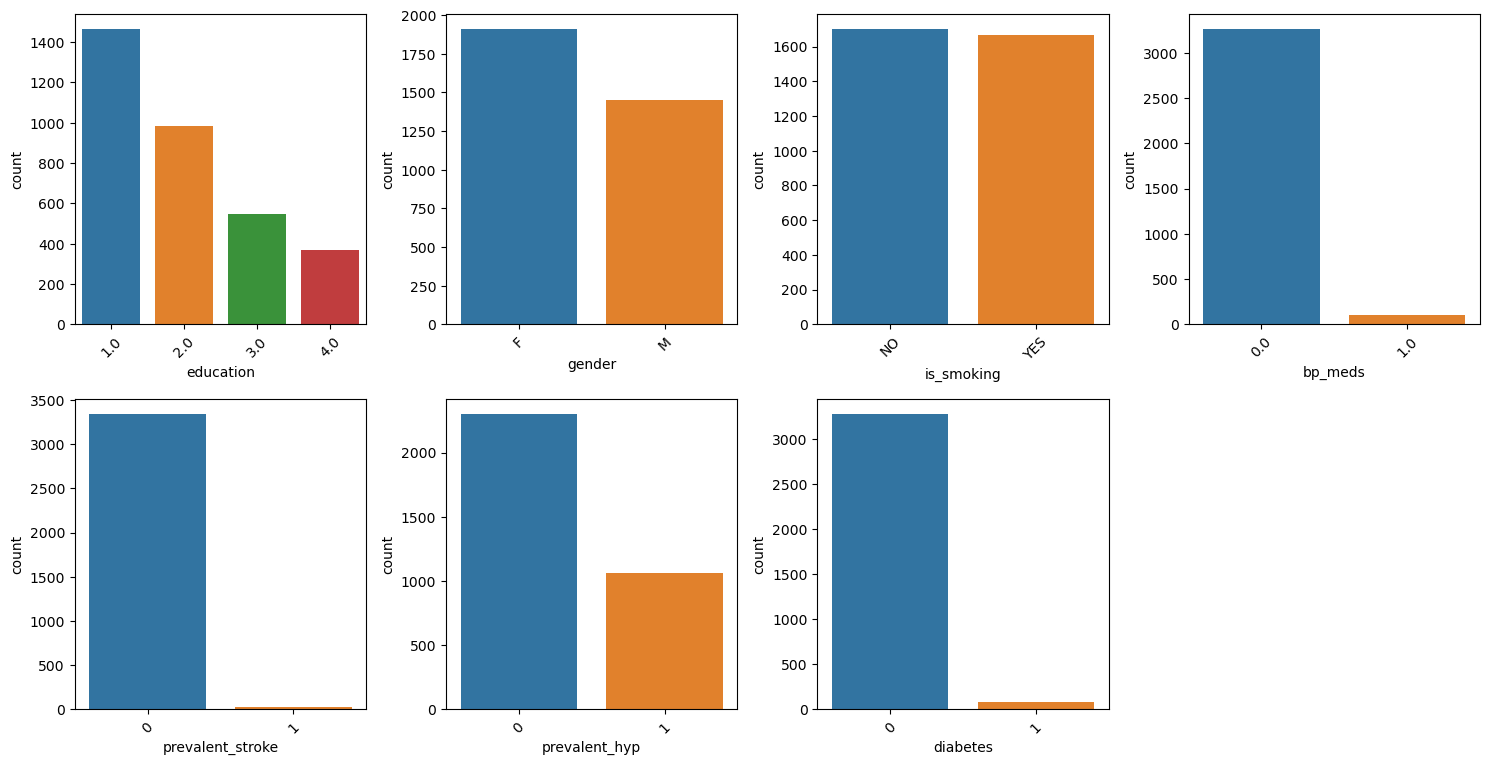

In [18]:
categorical_columns = df_copy.select_dtypes(include=['category']).columns.tolist()

# Create subplots
plt.figure(figsize=(15, 15))

# Loop through categorical columns and create subplots
for i, column in enumerate(categorical_columns):
    plt.subplot(4,4, i + 1)
    sns.countplot(data=df_copy, x=column)
    plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Saving the plot for reusing in PPT
plt.savefig('uni_cat.png')

# Show the plot
plt.show()


#### 2 (b) Univariate graphical EDA for Numerical Data

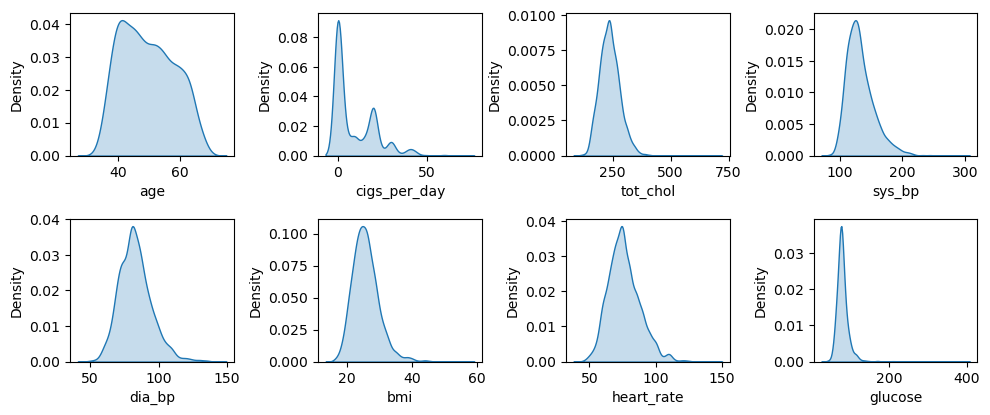

In [19]:
# Get columns with numerical data type
numerical_columns = df_copy.select_dtypes(include=['int64', 'float64']).drop(columns='ten_year_chd').columns.tolist()

# Create subplots
plt.figure(figsize=(10, 10))

# Loop through numerical columns and create subplots
for i, column in enumerate(numerical_columns):
    plt.subplot(5,4, i + 1)
    sns.kdeplot(data=df_copy, x=column,fill=True)

# Adjust layout
plt.tight_layout()

# Saving the plot for reusing in PPT
plt.savefig('uni_num.png')

# Show the plot
plt.show()

#### 3.(a) Bivariate analysis with Categorical Values

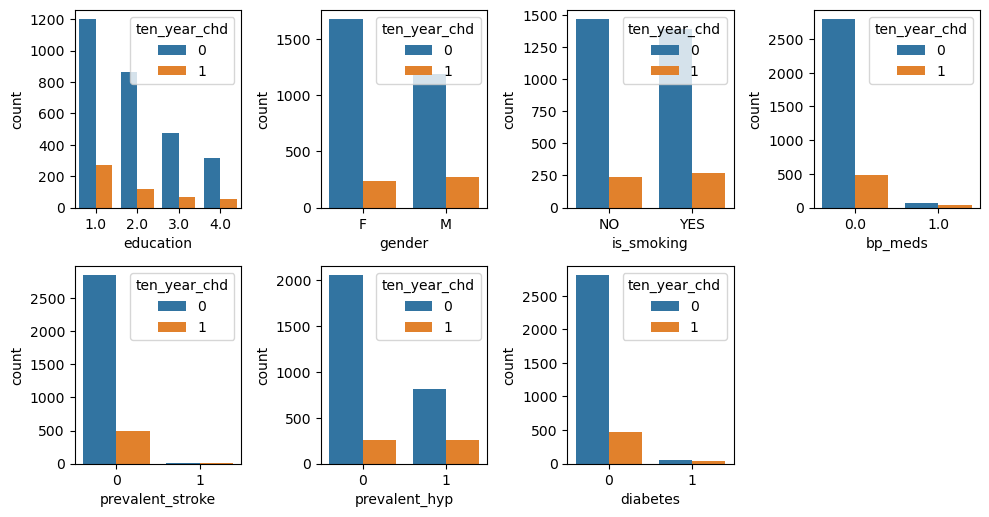

In [20]:
# Specify the target variable
target_variable = 'ten_year_chd'

# Get columns with categorical data type
categorical_columns = df_copy.select_dtypes(include=['category']).columns.tolist()

# Create subplots
plt.figure(figsize=(10, 10))

# Loop through categorical columns and create subplots
for i, column in enumerate(categorical_columns):
    plt.subplot(4, 4, i + 1)
    sns.countplot(x=column, hue=target_variable, data=df_copy)
# Adjust layout
plt.tight_layout()

# Saving the plot for reusing in PPT
plt.savefig('bi_cat.png')

# Show the plot
plt.show()


#### 3.(b) Bivariate analysis with Numerical Values

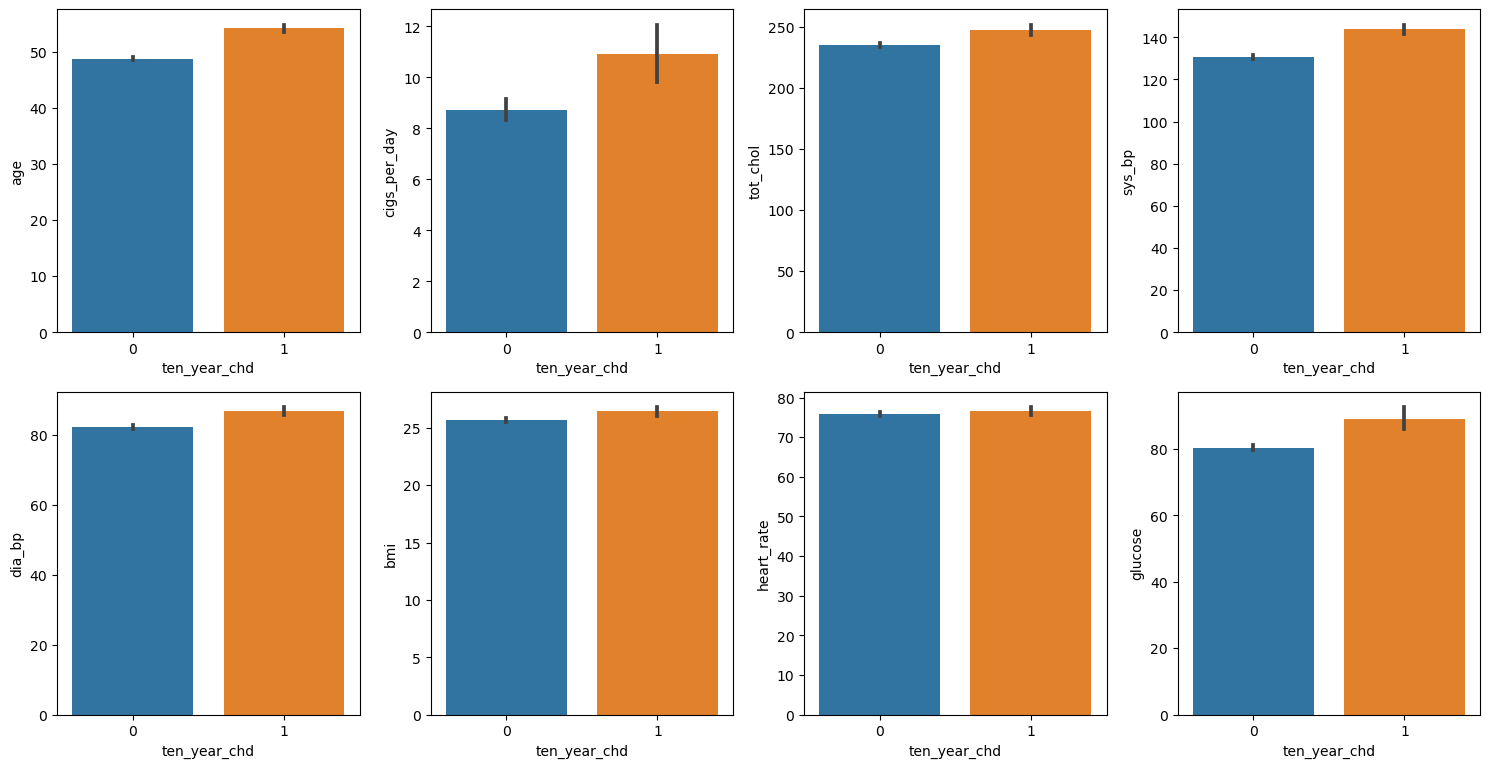

In [21]:
# Specify the target variable
target_variable = 'ten_year_chd'

# Get columns with numerical data type
numerical_columns = df_copy.select_dtypes(include=['int64', 'float64']).drop(columns='ten_year_chd').columns.tolist()

# Create subplots
plt.figure(figsize=(15, 15))

# Loop through numerical columns and create subplots
for i, column in enumerate(numerical_columns):
    plt.subplot(4, 4, i + 1)
    sns.barplot(data=df_copy, x=target_variable, y=column)

# Adjust layout
plt.tight_layout()

# Saving the plot for reusing in PPT
plt.savefig('bi_num.png')

# Show the plot
plt.show()


#### 4. Encoding Categorical Values

In [22]:
# Get columns with categorical data type
categorical_columns = df_copy.select_dtypes(include=['category','object']).columns.tolist()
# print(categorical_columns)

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in categorical_columns:
    df_copy[column] = label_encoder.fit_transform(df_copy[column])

# Display the updated DataFrame
df_copy.head()

,age,education,gender,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,tot_chol,sys_bp,dia_bp,bmi,heart_rate,glucose,ten_year_chd
0,64,1,0,1,3.0,0,0,0,0,221.0,148.0,85.0,25.793929,90.0,80.0,1
1,36,3,1,0,0.0,0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0
2,46,0,0,1,10.0,0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0
3,50,0,1,1,20.0,0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1
4,64,0,0,1,30.0,0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0


#### 4. Multivariate graphical EDA

#### a. Pair Plot

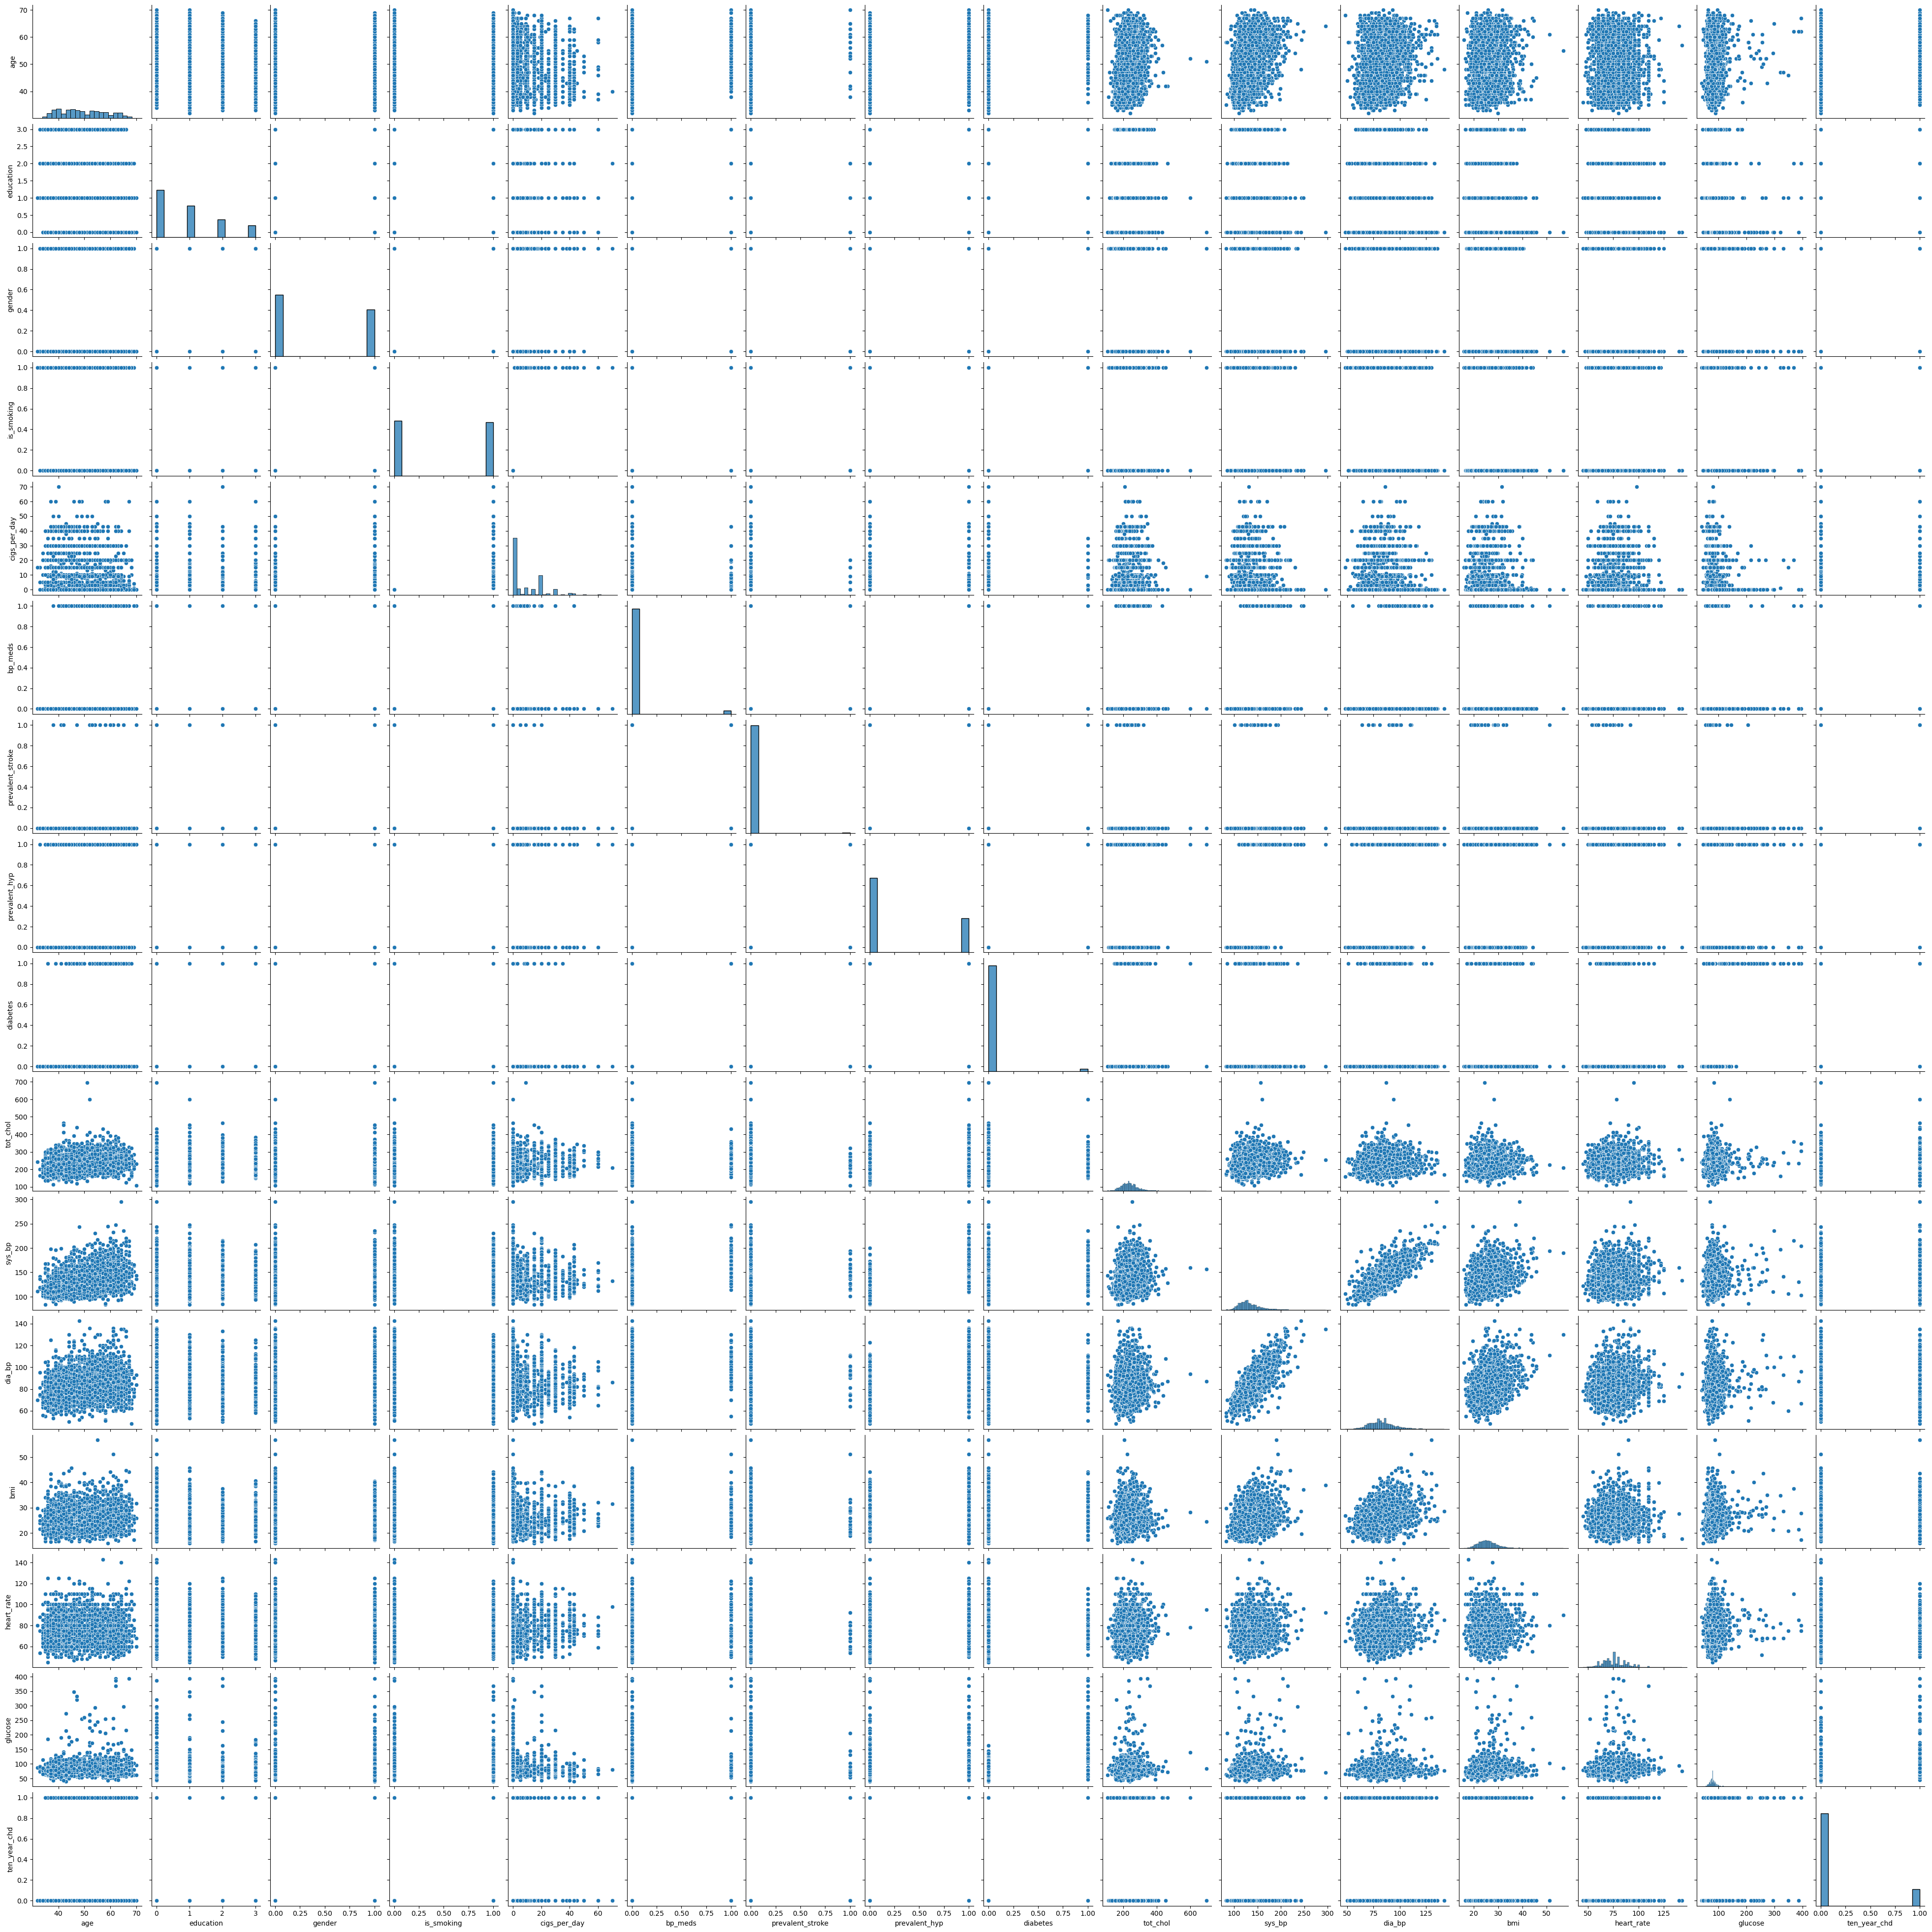

In [23]:
sns.pairplot(df_copy)
plt.show()

#### b. Heat Map

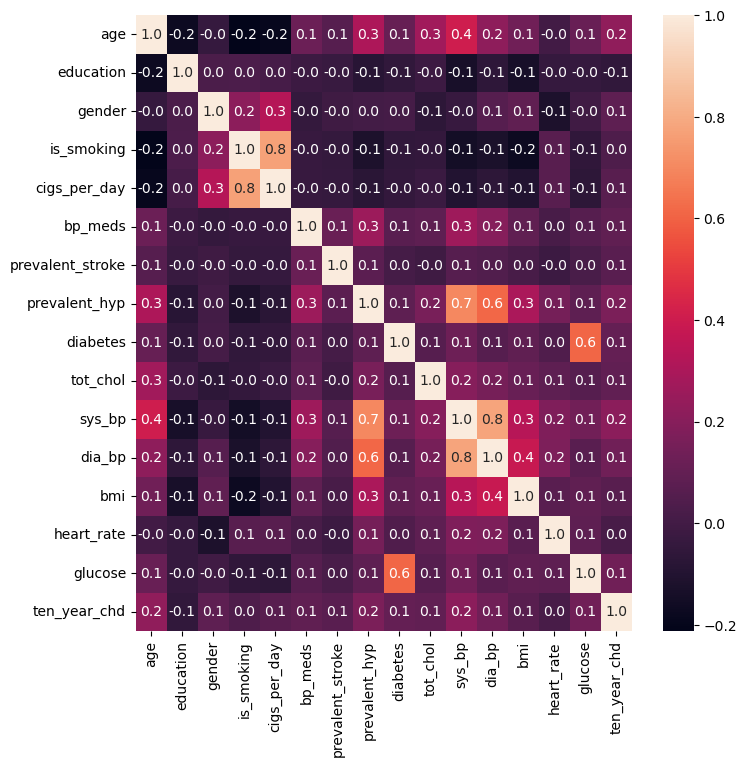

In [24]:
corr = df_copy.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, fmt='.1f', annot=True);
plt.show()

#### 5. Further Analysis

In [25]:
# People who have CHD, are they smokers? if they are, how many cigs a day did they smoke? 
df_smokers = df_copy[df_copy['is_smoking'] == 1.0]['cigs_per_day']
df_smokers.value_counts()[:5]

20.0    606
30.0    176
15.0    172
10.0    106
9.0     104
5.0     103
Name: cigs_per_day, dtype: int64

In [26]:
# Is there a probability that smokers are more prone to heart disease

df_smokers = df_copy[(df_copy['ten_year_chd'] == 1.0)]
df_smokers['is_smoking'].value_counts()/len(df_smokers)*100

1    53.634578
0    46.365422
Name: is_smoking, dtype: float64

In [27]:
# People who have CHD, what gender do they belong to predominently ?
df_gender= df_copy[df_copy['ten_year_chd'] == 1.0]['gender']
df_gender.value_counts()/len(df_gender)*100

1    53.045187
0    46.954813
Name: gender, dtype: float64

In [28]:
# People who have CHD, are they diabetic ?
df_diabetes = df_copy[df_copy['ten_year_chd'] == 1.0]['diabetes']
df_diabetes.value_counts()/len(df_diabetes)*100

0    93.516699
1     6.483301
Name: diabetes, dtype: float64

In [29]:
# People who have CHD, what is their glucose level like ?
df_diabetes = df_copy[df_copy['ten_year_chd'] == 1.0]['glucose']
df_diabetes.value_counts()

78.0     53
75.0     22
83.0     21
72.0     17
76.0     17
         ..
256.0     1
113.0     1
145.0     1
205.0     1
274.0     1
Name: glucose, Length: 95, dtype: int64

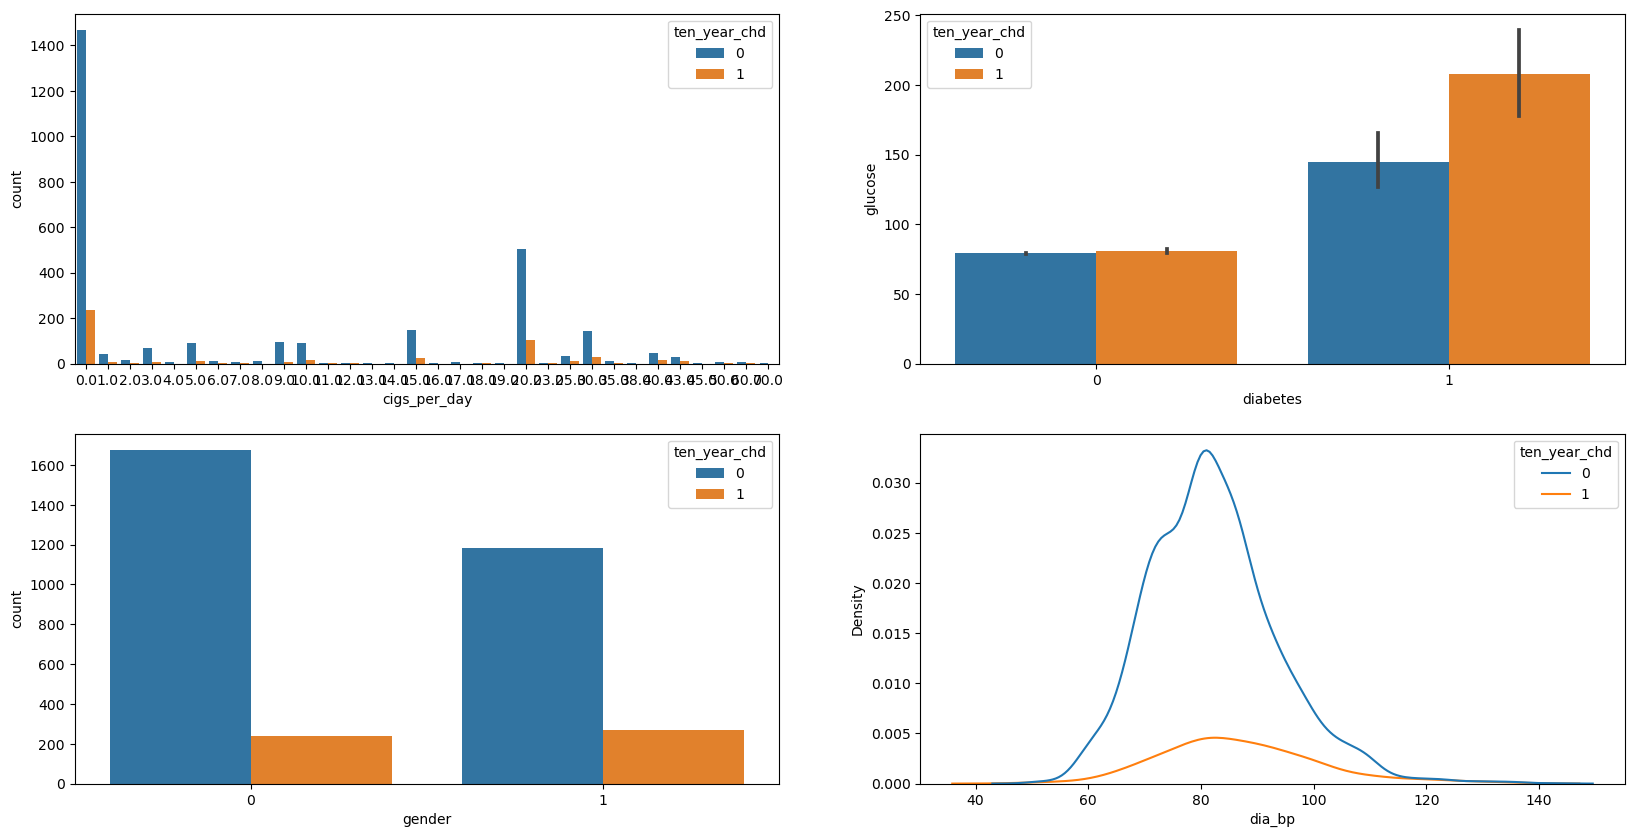

In [30]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sns.countplot(x = 'cigs_per_day', hue = 'ten_year_chd', data=df_copy, ax=axes[0][0])
sns.barplot(data=df_copy, x='diabetes', y='glucose', hue='ten_year_chd', ax=axes[0][1])
sns.countplot(data=df_copy, x='gender', hue='ten_year_chd', ax=axes[1][0])
sns.kdeplot(data=df_copy, x='dia_bp', hue='ten_year_chd', ax=axes[1][1])
plt.savefig('multi.png')

### Feature Selection

In [31]:
# High correlation between sys_bp, dia_bp, 

def blood_presure_classification(sys_bp, dia_bp):
    if sys_bp < 90 and dia_bp < 60:
        return 0 # 'Low BP'
    elif sys_bp < 120 and dia_bp < 80:
        return 1 # 'Normal BP'
    elif sys_bp < 140 and dia_bp < 90:
        return 2 # 'Pre Hypertension'
    elif sys_bp < 160 and dia_bp < 100:
        return 3 # 'Hypertension Stage 1'
    elif sys_bp < 180 and dia_bp < 120:
        return 4 # 'Hypertension Stage 2'
    return 5 #'Hypertension Stage 3' 
        
    
df_copy['hypertension'] = df_copy.apply(lambda x: blood_presure_classification(x['sys_bp'],x['dia_bp']),axis=1)
df_copy.head()

,age,education,gender,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,tot_chol,sys_bp,dia_bp,bmi,heart_rate,glucose,ten_year_chd,hypertension
0,64,1,0,1,3.0,0,0,0,0,221.0,148.0,85.0,25.793929,90.0,80.0,1,3
1,36,3,1,0,0.0,0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0,4
2,46,0,0,1,10.0,0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0,1
3,50,0,1,1,20.0,0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1,3
4,64,0,0,1,30.0,0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0,2


In [32]:
# is_smoking does'nt contribute to the target variable, the details about this is given in cigs_per_day
# dia_bp is starting to explain sys_bp, sys_bp provides more insights about health than dia_bp

df_copy.drop(columns=['sys_bp','dia_bp','is_smoking',],inplace=True)

In [33]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3367 entries, 0 to 3389
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3367 non-null   int64  
 1   education         3367 non-null   int64  
 2   gender            3367 non-null   int32  
 3   cigs_per_day      3367 non-null   float64
 4   bp_meds           3367 non-null   int64  
 5   prevalent_stroke  3367 non-null   int64  
 6   prevalent_hyp     3367 non-null   int64  
 7   diabetes          3367 non-null   int64  
 8   tot_chol          3367 non-null   float64
 9   bmi               3367 non-null   float64
 10  heart_rate        3367 non-null   float64
 11  glucose           3367 non-null   float64
 12  ten_year_chd      3367 non-null   int64  
 13  hypertension      3367 non-null   int64  
dtypes: float64(5), int32(1), int64(8)
memory usage: 381.4 KB


In [34]:
# Identifying Features and Target variables

X = df_copy.drop(columns=['ten_year_chd',])
y = df_copy.iloc[:,-2:-1]

display(X.head())
display(y.head())

,age,education,gender,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,tot_chol,bmi,heart_rate,glucose,hypertension
0,64,1,0,3.0,0,0,0,0,221.0,25.793929,90.0,80.0,3
1,36,3,1,0.0,0,0,1,0,212.0,29.770000,72.0,75.0,4
2,46,0,0,10.0,0,0,0,0,250.0,20.350000,88.0,94.0,1
3,50,0,1,20.0,0,0,1,0,233.0,28.260000,68.0,94.0,3
4,64,0,0,30.0,0,0,0,0,241.0,26.420000,70.0,77.0,2


,ten_year_chd
0,1
1,0
2,0
3,1
4,0


In [35]:
df_copy['ten_year_chd'].value_counts()

0    2858
1     509
Name: ten_year_chd, dtype: int64

In [36]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_copy.drop('ten_year_chd', axis=1), df_copy['ten_year_chd'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### Preprocessing

#### 1. Split dataset into train and test

In [37]:
# Split X and y into training and test set in 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_Y, test_size=0.30 , random_state=1)

In [38]:
X_train.head(2)

,age,education,gender,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,tot_chol,bmi,heart_rate,glucose,hypertension
2594,41,2,1,0.000000,0,0,0,0,256.000000,26.380000,60.000000,65.000000,1
4692,48,0,0,31.605108,0,0,0,0,337.531237,29.686758,80.963065,76.678978,2


### Modelling

#### 1. Logistic Regression

In [39]:
# Create a LogisticRegression model
lr = LogisticRegression(max_iter=100)

# Fit the model to the training data
lr.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = lr.predict(X_train)

# Make predictions on the test data
y_pred_test = lr.predict(X_test)

acc_score_train = np.around(accuracy_score(y_train, y_pred_train), 2)
prec_score_train = np.around(precision_score(y_train, y_pred_train), 2)
recall_score_train = np.around(recall_score(y_train, y_pred_train), 2)
f1_score_train = np.around(f1_score(y_train, y_pred_train), 2)

acc_score_test = np.around(accuracy_score(y_test, y_pred_test), 2)
prec_score_test = np.around(precision_score(y_test, y_pred_test), 2)
recall_score_test = np.around(recall_score(y_test, y_pred_test), 2)
f1_score_test = np.around(f1_score(y_test, y_pred_test), 2)

# Create a DataFrame to store the results
results = pd.DataFrame([[acc_score_train, acc_score_test, prec_score_train, prec_score_test,
                         recall_score_train, recall_score_test,f1_score_train,f1_score_test]],
                          columns=['Accuracy (Train)','Accuracy (Test)', 'Precision (Train)',
                                   'Precision (Test)', 'Recall Score (Train)',  'Recall Score (Test)',
                                    'F1-Score (Train)','F1-Score (Test)'],
                          index=['Logistic Regression'])

# Print the results
display(results)


,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall Score (Train),Recall Score (Test),F1-Score (Train),F1-Score (Test)
Logistic Regression,0.67,0.64,0.65,0.62,0.71,0.72,0.68,0.67


#### 2. Decision Tree Classifier

In [40]:
# Create a DecisionTreeRegressor model
dt = DecisionTreeClassifier(max_depth=15)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = dt.predict(X_train)

# Make predictions on the test data
y_pred_test = dt.predict(X_test)

acc_score_train = np.around(accuracy_score(y_train, y_pred_train), 2)
prec_score_train = np.around(precision_score(y_train, y_pred_train), 2)
recall_score_train = np.around(recall_score(y_train, y_pred_train), 2)
f1_score_train = np.around(f1_score(y_train, y_pred_train), 2)

acc_score_test = np.around(accuracy_score(y_test, y_pred_test), 2)
prec_score_test = np.around(precision_score(y_test, y_pred_test), 2)
recall_score_test = np.around(recall_score(y_test, y_pred_test), 2)
f1_score_test = np.around(f1_score(y_test, y_pred_test), 2)

# Create a DataFrame to store the results
dt_results = pd.DataFrame([[acc_score_train, acc_score_test, prec_score_train, prec_score_test,
                         recall_score_train, recall_score_test,f1_score_train,f1_score_test]],
                          columns=['Accuracy (Train)','Accuracy (Test)', 'Precision (Train)',
                                   'Precision (Test)', 'Recall Score (Train)',  'Recall Score (Test)',
                                  'F1-Score (Train)','F1-Score (Test)'],
                          index=['Decision Tree Classifier'])

# Concatenate the results to the existing DataFrame
results = pd.concat([results, dt_results])

# Print the results
display(results)


,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall Score (Train),Recall Score (Test),F1-Score (Train),F1-Score (Test)
Logistic Regression,0.67,0.64,0.65,0.62,0.71,0.72,0.68,0.67
Decision Tree Classifier,0.96,0.75,0.96,0.73,0.97,0.79,0.96,0.76


#### 3. Random Forest Classifier

In [41]:
# Create a RandomForestRegressor model
rf = RandomForestClassifier(max_depth=15)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = rf.predict(X_train)

# Make predictions on the test data
y_pred_test = rf.predict(X_test)

acc_score_train = np.around(accuracy_score(y_train, y_pred_train), 2)
prec_score_train = np.around(precision_score(y_train, y_pred_train), 2)
recall_score_train = np.around(recall_score(y_train, y_pred_train), 2)
f1_score_train = np.around(f1_score(y_train, y_pred_train), 2)

acc_score_test = np.around(accuracy_score(y_test, y_pred_test), 2)
prec_score_test = np.around(precision_score(y_test, y_pred_test), 2)
recall_score_test = np.around(recall_score(y_test, y_pred_test), 2)
f1_score_test = np.around(f1_score(y_test, y_pred_test), 2)

# Create a DataFrame to store the results
rf_results = pd.DataFrame([[acc_score_train, acc_score_test, prec_score_train, prec_score_test,
                         recall_score_train, recall_score_test,f1_score_train,f1_score_test]],
                          columns=['Accuracy (Train)','Accuracy (Test)', 'Precision (Train)',
                                   'Precision (Test)', 'Recall Score (Train)',  'Recall Score (Test)',
                                   'F1-Score (Train)','F1-Score (Test)'],
                          index=['Random Forest Classifier'])

# Concatenate the results to the existing DataFrame
results = pd.concat([results, rf_results])

# Print the results
display(results)

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall Score (Train),Recall Score (Test),F1-Score (Train),F1-Score (Test)
Logistic Regression,0.67,0.64,0.65,0.62,0.71,0.72,0.68,0.67
Decision Tree Classifier,0.96,0.75,0.96,0.73,0.97,0.79,0.96,0.76
Random Forest Classifier,1.00,0.85,0.99,0.82,1.00,0.89,1.00,0.86


#### 4. K Nearest Neighbours (KNN)

In [42]:
# Create a KNeighborsClassification model
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = knn.predict(X_train)

# Make predictions on the test data
y_pred_test = knn.predict(X_test)

acc_score_train = np.around(accuracy_score(y_train, y_pred_train), 2)
prec_score_train = np.around(precision_score(y_train, y_pred_train), 2)
recall_score_train = np.around(recall_score(y_train, y_pred_train), 2)
f1_score_train = np.around(f1_score(y_train, y_pred_train), 2)

acc_score_test = np.around(accuracy_score(y_test, y_pred_test), 2)
prec_score_test = np.around(precision_score(y_test, y_pred_test), 2)
recall_score_test = np.around(recall_score(y_test, y_pred_test), 2)
f1_score_test = np.around(f1_score(y_test, y_pred_test), 2)

# Create a DataFrame to store the results
knn_results = pd.DataFrame([[acc_score_train, acc_score_test, prec_score_train, prec_score_test,
                         recall_score_train, recall_score_test,f1_score_train,f1_score_test]],
                          columns=['Accuracy (Train)','Accuracy (Test)', 'Precision (Train)',
                                   'Precision (Test)', 'Recall Score (Train)',  'Recall Score (Test)',
                                   'F1-Score (Train)','F1-Score (Test)'],
                          index=['K-Nearest Neighbors'])

# Concatenate the results to the existing DataFrame
results = pd.concat([results, knn_results])

# Print the results
display(results)


,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall Score (Train),Recall Score (Test),F1-Score (Train),F1-Score (Test)
Logistic Regression,0.67,0.64,0.65,0.62,0.71,0.72,0.68,0.67
Decision Tree Classifier,0.96,0.75,0.96,0.73,0.97,0.79,0.96,0.76
Random Forest Classifier,1.00,0.85,0.99,0.82,1.00,0.89,1.00,0.86
K-Nearest Neighbors,0.90,0.82,0.84,0.75,0.99,0.96,0.91,0.84


In [43]:
accuracy_rate = []

# May take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,oversampled_X,oversampled_Y,cv=10)
    accuracy_rate.append(score.mean())
    
error_rate = []

# May take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,oversampled_X,oversampled_Y,cv=10)
    error_rate.append(1-score.mean())


Text(0, 0.5, 'Accuracy Rate')

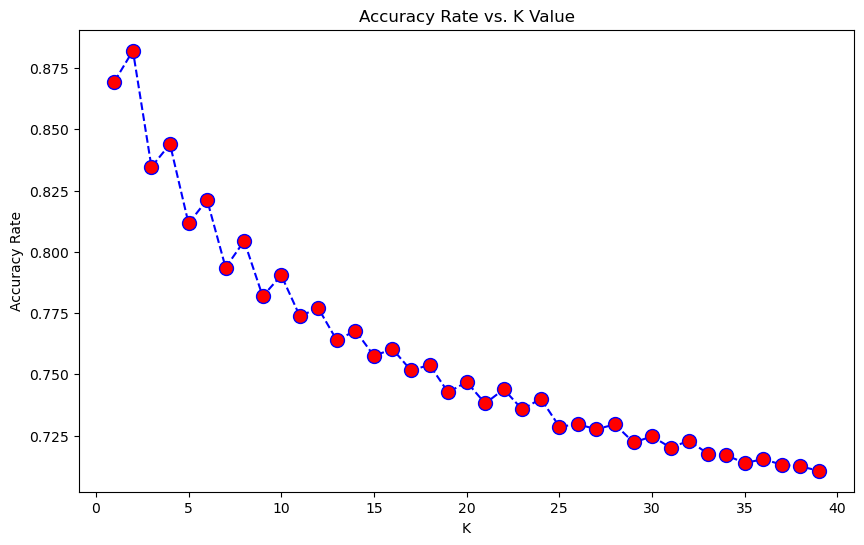

In [44]:
plt.figure(figsize=(10,6))
# plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
#         markerfacecolor='red', markersize=10)
# plt.title('Error Rate vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Error Rate')

plt.plot(range(1,40),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

#### 5. Support Vector Machine (SVM)

In [45]:
# Create a Support Vector Machine (SVM) model
svm = SVC()

# Fit the model to the training data
svm.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = svm.predict(X_train)

# Make predictions on the test data
y_pred_test = svm.predict(X_test)

acc_score_train = np.around(accuracy_score(y_train, y_pred_train), 2)
prec_score_train = np.around(precision_score(y_train, y_pred_train), 2)
recall_score_train = np.around(recall_score(y_train, y_pred_train), 2)
f1_score_train = np.around(f1_score(y_train, y_pred_train), 2)

acc_score_test = np.around(accuracy_score(y_test, y_pred_test), 2)
prec_score_test = np.around(precision_score(y_test, y_pred_test), 2)
recall_score_test = np.around(recall_score(y_test, y_pred_test), 2)
f1_score_test = np.around(f1_score(y_test, y_pred_test), 2)

# Create a DataFrame to store the results
svm_results = pd.DataFrame([[acc_score_train, acc_score_test, prec_score_train, prec_score_test,
                         recall_score_train, recall_score_test,f1_score_train,f1_score_test]],
                          columns=['Accuracy (Train)','Accuracy (Test)', 'Precision (Train)',
                                   'Precision (Test)', 'Recall Score (Train)',  'Recall Score (Test)',
                                   'F1-Score (Train)','F1-Score (Test)'],
                          index=['Support Vector Machine'])

# Concatenate the results to the existing DataFrame
results = pd.concat([results, svm_results])

# Print the results
display(results)


,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall Score (Train),Recall Score (Test),F1-Score (Train),F1-Score (Test)
Logistic Regression,0.67,0.64,0.65,0.62,0.71,0.72,0.68,0.67
Decision Tree Classifier,0.96,0.75,0.96,0.73,0.97,0.79,0.96,0.76
Random Forest Classifier,1.00,0.85,0.99,0.82,1.00,0.89,1.00,0.86
K-Nearest Neighbors,0.90,0.82,0.84,0.75,0.99,0.96,0.91,0.84
Support Vector Machine,0.65,0.65,0.63,0.64,0.72,0.71,0.67,0.67


#### 6. Naive Bayes Classifier

In [46]:
# Create a Naive Bayes Classifier model
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = nb.predict(X_train)

# Make predictions on the test data
y_pred_test = nb.predict(X_test)

acc_score_train = np.around(accuracy_score(y_train, y_pred_train), 2)
prec_score_train = np.around(precision_score(y_train, y_pred_train), 2)
recall_score_train = np.around(recall_score(y_train, y_pred_train), 2)
f1_score_train = np.around(f1_score(y_train, y_pred_train), 2)

acc_score_test = np.around(accuracy_score(y_test, y_pred_test), 2)
prec_score_test = np.around(precision_score(y_test, y_pred_test), 2)
recall_score_test = np.around(recall_score(y_test, y_pred_test), 2)
f1_score_test = np.around(f1_score(y_test, y_pred_test), 2)

# Create a DataFrame to store the results
nb_results = pd.DataFrame([[acc_score_train, acc_score_test, prec_score_train, prec_score_test,
                         recall_score_train, recall_score_test,f1_score_train,f1_score_test]],
                          columns=['Accuracy (Train)','Accuracy (Test)', 'Precision (Train)',
                                   'Precision (Test)', 'Recall Score (Train)',  'Recall Score (Test)',
                                   'F1-Score (Train)','F1-Score (Test)'],
                          index=['Guassian NB Classifier'])

# Concatenate the results to the existing DataFrame
results = pd.concat([results, nb_results])

# Print the results
display(results)

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall Score (Train),Recall Score (Test),F1-Score (Train),F1-Score (Test)
Logistic Regression,0.67,0.64,0.65,0.62,0.71,0.72,0.68,0.67
Decision Tree Classifier,0.96,0.75,0.96,0.73,0.97,0.79,0.96,0.76
Random Forest Classifier,1.00,0.85,0.99,0.82,1.00,0.89,1.00,0.86
K-Nearest Neighbors,0.90,0.82,0.84,0.75,0.99,0.96,0.91,0.84
Support Vector Machine,0.65,0.65,0.63,0.64,0.72,0.71,0.67,0.67
Guassian NB Classifier,0.66,0.63,0.68,0.65,0.60,0.58,0.64,0.61


#### Further Analysis of Decision Tree

In [47]:
# Create a DecisionTreeRegressor model
dt = DecisionTreeClassifier(max_depth=15)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = dt.predict(X_train)

# Make predictions on the test data
y_pred_dt = dt.predict(X_test)

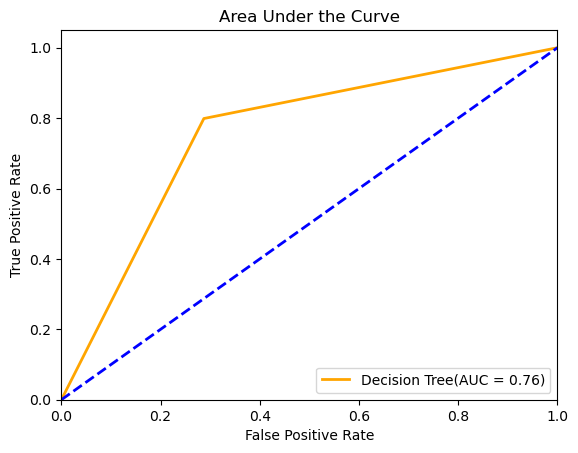

In [48]:
from sklearn.metrics import roc_curve, auc

fpr_dt,tpr_dt,_= roc_curve(y_test,y_pred_dt)
roc_auc_dt = auc(fpr_dt,tpr_dt)

plt.figure(1)
lw=2
plt.plot(fpr_dt,tpr_dt,color='orange',lw=lw,label='Decision Tree(AUC = %0.2f)'%roc_auc_dt)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the Curve")
# plt.legend(loc="upper left")
plt.legend(loc="lower right")

In [49]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75       860
           1       0.73      0.80      0.77       855

    accuracy                           0.76      1715
   macro avg       0.76      0.76      0.76      1715
weighted avg       0.76      0.76      0.76      1715



In [50]:
conf_matrix = confusion_matrix(y_test,y_pred_test)
conf_matrix

array([[591, 269],
       [361, 494]], dtype=int64)

In [52]:
lst = [i for i in range(1,11)]
print(lst)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [53]:
lst[::-1]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]